<a href="https://colab.research.google.com/github/RashmikaReddy/Quora-Question-Similarity/blob/main/TFIDF_Quora_Question_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_tfidf = pd.read_csv("/content/drive/MyDrive/QuoraQuestionSimilarity/questions.csv")

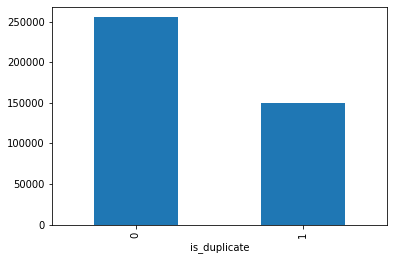

In [ ]:
import seaborn as sns
%matplotlib inline
df_tfidf.dropna(axis=0, inplace=True)
df_tfidf.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
df_tfidf.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
a = 0 
for i in range(a,a+10):
    print(df_tfidf.question1[i])
    print(df_tfidf.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

In [ ]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#     # all numbers should separate from words, this is too aggressive
    
#     def pad_number(pattern):
#         matched_string = pattern.group(0)
#         return pad_str(matched_string)
#     text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
#    def pad_pattern(pattern):
#        matched_string = pattern.group(0)
#       return pad_str(matched_string)
#    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text
    
df_tfidf['question1'] = df_tfidf['question1'].apply(clean)
df_tfidf['question2'] = df_tfidf['question2'].apply(clean)

In [ ]:
a = 0 
for i in range(a,a+10):
    print(df_tfidf.question1[i])
    print(df_tfidf.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

In [ ]:
#Bag of Words and XGB model on BOW
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat((df_tfidf['question1'],df_tfidf['question2'])).unique())
trainq1_trans = count_vect.transform(df_tfidf['question1'].values)
trainq2_trans = count_vect.transform(df_tfidf['question2'].values)
labels = df_tfidf['is_duplicate'].values


In [ ]:
trainq1_trans

<404348x105112 sparse matrix of type '<class 'numpy.int64'>'
	with 4221125 stored elements in Compressed Sparse Row format>

In [ ]:
import scipy
from scipy.sparse import hstack
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)



In [ ]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))

print(classification_report(y_valid, xgb_prediction))

training score: 0.830410003634199
validation score: 0.7614430800746755
              precision    recall  f1-score   support

           0       0.80      0.90      0.84     84355
           1       0.77      0.60      0.68     49080

    accuracy                           0.79    133435
   macro avg       0.79      0.75      0.76    133435
weighted avg       0.79      0.79      0.78    133435



In [ ]:
#Calculating LogLoss to compare XGB with BOW and XGB with TF-IDF weighted word2vec
from sklearn.metrics import accuracy_score, log_loss

log_loss_test = log_loss(y_valid, xgb_prediction, eps=1e-15)
print("log loss is",log_loss_test)


log loss is 9.117285567496445


In [ ]:
#TF-IDF at word level and XgBoost
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(pd.concat((df_tfidf['question1'],df_tfidf['question2'])).unique())
trainq1_trans = tfidf_vect.transform(df_tfidf['question1'].values)
trainq2_trans = tfidf_vect.transform(df_tfidf['question2'].values)
labels = df_tfidf['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model_1 = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model_1.predict(X_valid)


In [ ]:
print('word level tf-idf training score:', f1_score(y_train, xgb_model_1.predict(X_train), average='macro'))
print('word level tf-idf validation score:', f1_score(y_valid, xgb_model_1.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

word level tf-idf training score: 0.8909679680674745
word level tf-idf validation score: 0.7637331832057742
              precision    recall  f1-score   support

           0       0.80      0.90      0.85     84355
           1       0.78      0.61      0.68     49080

    accuracy                           0.79    133435
   macro avg       0.79      0.75      0.76    133435
weighted avg       0.79      0.79      0.79    133435



In [ ]:
#Calculating LogLoss to compare XGB with BOW and XGB with TF-IDF weighted word2vec
from sklearn.metrics import accuracy_score, log_loss

log_loss_test = log_loss(y_valid, xgb_model_1.predict(X_valid), eps=1e-15)
print("log loss is",log_loss_test)


log loss is 7.194864121231109


In [ ]:
#TF-IDF at word level and with ngrams - XGBoost
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(pd.concat((df_tfidf['question1'],df_tfidf['question2'])).unique())
trainq1_trans = tfidf_vect_ngram.transform(df_tfidf['question1'].values)
trainq2_trans = tfidf_vect_ngram.transform(df_tfidf['question2'].values)
labels = df_tfidf['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model_2 = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model_2.predict(X_valid)
print('n-gram level tf-idf training score:', f1_score(y_train, xgb_model_2.predict(X_train), average='macro'))
print('n-gram level tf-idf validation score:', f1_score(y_valid, xgb_model_2.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

n-gram level tf-idf training score: 0.7424796197136108
n-gram level tf-idf validation score: 0.6788727792847618
              precision    recall  f1-score   support

           0       0.73      0.92      0.81     84355
           1       0.75      0.43      0.54     49080

    accuracy                           0.74    133435
   macro avg       0.74      0.67      0.68    133435
weighted avg       0.74      0.74      0.71    133435

